# TCAV — Images 

This notebook trains CAVs and plots variability.


In [1]:

# Import shim
import sys, pathlib
for p in (pathlib.Path.cwd().parent / "src", pathlib.Path.cwd().parents[1] / "src"):
    if (p / "tcavlab").exists():
        sys.path.insert(0, str(p))
import tcavlab
print("tcavlab path:", tcavlab.__file__)


tcavlab path: /home/said/tcav_var/variability-of-tcav/src/tcavlab/__init__.py


In [2]:

import os, pickle
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from tcavlab import (
    ExperimentConfig, DatasetConfig,
    Concept, train_cav, sample_train_cav, method_names,
    get_activations_from_tensor, get_gradient_at_layer,
    plot_variance_vs_n, plot_tcav_score_variance,
    precompute_cavs_for_layer,
    cav_variability_analysis_cached, sensitivity_variance_analysis_cached, tcav_score_variance_analysis_cached,
)
from tcavlab.plots import plot_surround_assumption, plot_pca_projection
from tcavlab.assumptions import check_surround_assumption
from tcavlab.models.vision import available_models, choose_model
from tcavlab.datasets.images import load_images_as_tensor
from tcavlab.utils import device_auto, set_all_seeds, ensure_dir
from tcavlab.analysis_utils import load_cav_vector_variance_data_cached, precompute_gradients_for_class


In [3]:

# -----------------------------
# 1) Configuration
# -----------------------------
METHOD = "dom"        # "dom", "logistic", "hinge"
MODEL = "resnet50"    # "resnet50", "googlenet", "mobilenet_v3_large", "vit_b_16"
print("Available models:", available_models())

dataset = DatasetConfig(                    
    name="images",
    concepts=["striped", "zigzagged", "dotted"],
    target_class_name="zebra",
    target_class_index=340,
    data_paths={
        "concepts_root": "../concepts",
        "random_dir": "../random",
        "class_dir": "../zebra",
    },
)

cfg = ExperimentConfig(
    dataset=dataset,
    method=METHOD,
    model_key=MODEL,
    n_values=range(10, 310, 10),
    runs=10,
    sets_per_run=10,
    out_dir=f"artifacts/images/{MODEL}/{METHOD}",  # CAV files will be saved under: out_dir/{layer}/{concept}/{n}/run_{i}.pkl
    seed=42,
)

set_all_seeds(cfg.seed)
DEVICE = device_auto()
print("Using device:", DEVICE)

# Cache flags
CACHE_DIR = os.path.join(cfg.out_dir, "cache")
LOAD_IF_EXISTS = False
os.makedirs(CACHE_DIR, exist_ok=True)


Available models: ['resnet50', 'googlenet', 'mobilenet_v3_large', 'vit_b_16']
Using device: cuda


In [4]:

# -----------------------------
# 2) Model and data
# -----------------------------
model, layers, preprocess, device = choose_model(cfg.model_key)
print("Layers:", layers)

concept_tensors = {}
for c in cfg.dataset.concepts:
    concept_dir = os.path.join(cfg.dataset.data_paths["concepts_root"], c)
    concept_tensors[c] = load_images_as_tensor(concept_dir, preprocess, DEVICE)
    print(f"Loaded '{c}' with {len(concept_tensors[c])} images")

random_tensor = load_images_as_tensor(cfg.dataset.data_paths["random_dir"], preprocess, DEVICE)
class_tensor = load_images_as_tensor(cfg.dataset.data_paths["class_dir"], preprocess, DEVICE)
print("Loaded random:", len(random_tensor), "target class:", len(class_tensor))


Layers: ['layer2', 'layer3', 'layer4']
Loaded 'striped' with 50 images
Loaded 'zigzagged' with 50 images
Loaded 'dotted' with 50 images
Loaded random: 455 target class: 50


In [5]:

# -----------------------------
# 3) Precompute and save CAVs (per concept & layer)
# -----------------------------
for layer in layers:
    print(f"Calculating CAVs for layer: {layer}")
    for concept in cfg.dataset.concepts:
        concept_acts = get_activations_from_tensor(model, concept_tensors[concept], layer, DEVICE).numpy()
        random_acts  = get_activations_from_tensor(model, random_tensor, layer, DEVICE).numpy()
        base_dir = os.path.join(cfg.out_dir, layer, concept)
        ensure_dir(base_dir)
        precompute_cavs_for_layer(
            X_pos=concept_acts,
            X_neg=random_acts,
            layer_name=layer,
            method=cfg.method,
            n_values=cfg.n_values,
            runs=cfg.runs,
            sets_per_run=cfg.sets_per_run,
            out_dir=base_dir,
            seed=cfg.seed,
        )
print("CAV files saved under", cfg.out_dir)


Calculating CAVs for layer: layer2
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_0.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_1.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_2.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_3.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_4.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_5.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_6.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_7.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_8.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_9.pkl
CAV file already exists, skipping: 

===== Analyzing Layer: layer2 =====
Fit: $ 6.3/N \; + \; 4.85\times 10^{-9} $
Plot saved to artifacts/images/resnet50/dom/plots/cav_vector_variance_resnet50_layer2_dom.pdf


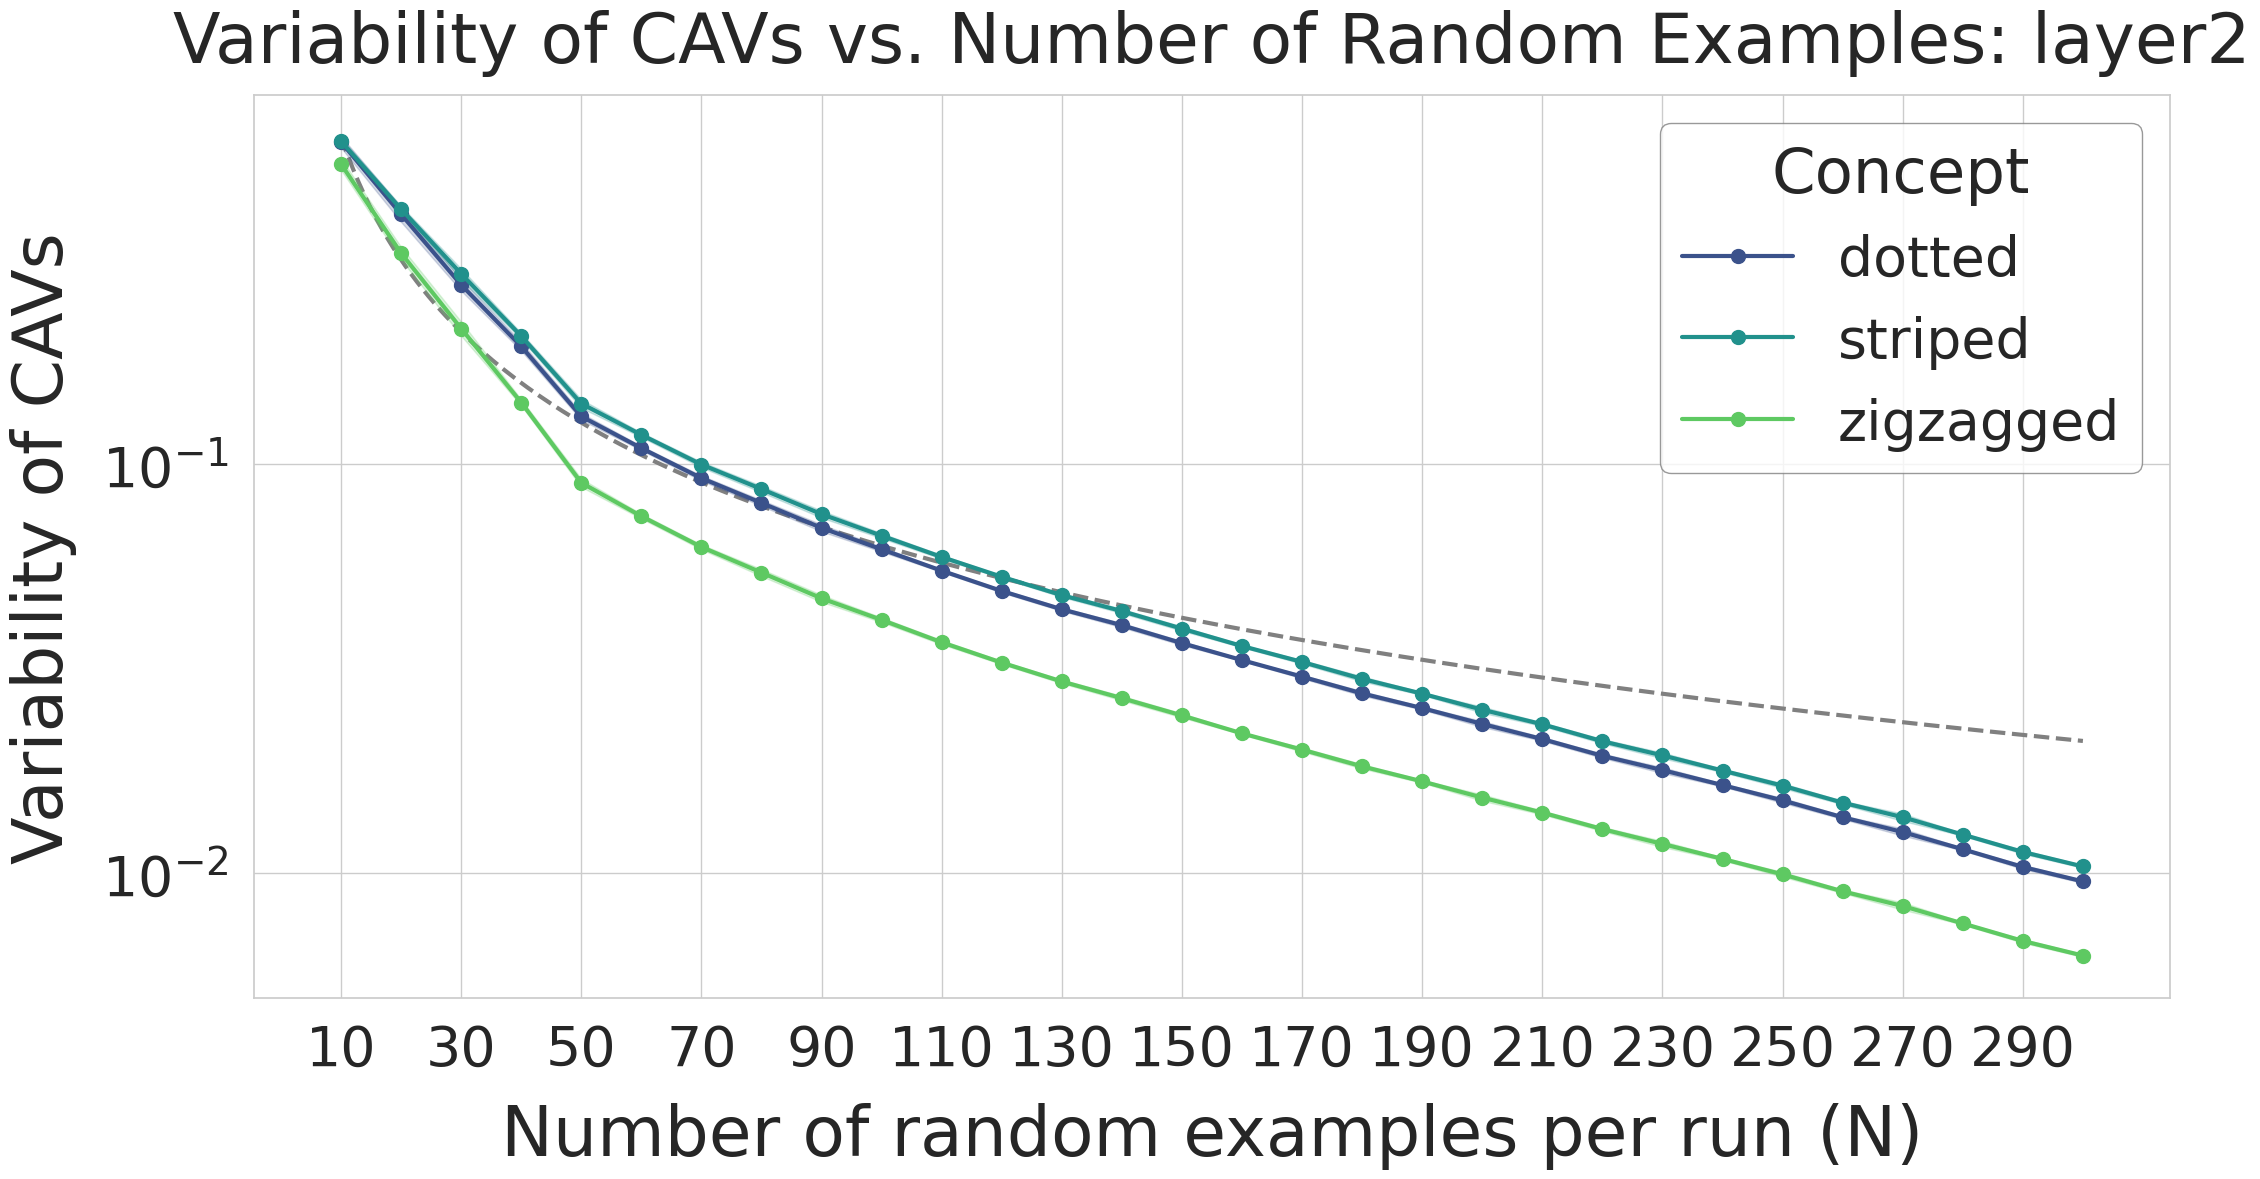

===== Analyzing Layer: layer3 =====
Fit: $ 3.84/N \; + \; 6.88\times 10^{-10} $
Plot saved to artifacts/images/resnet50/dom/plots/cav_vector_variance_resnet50_layer3_dom.pdf


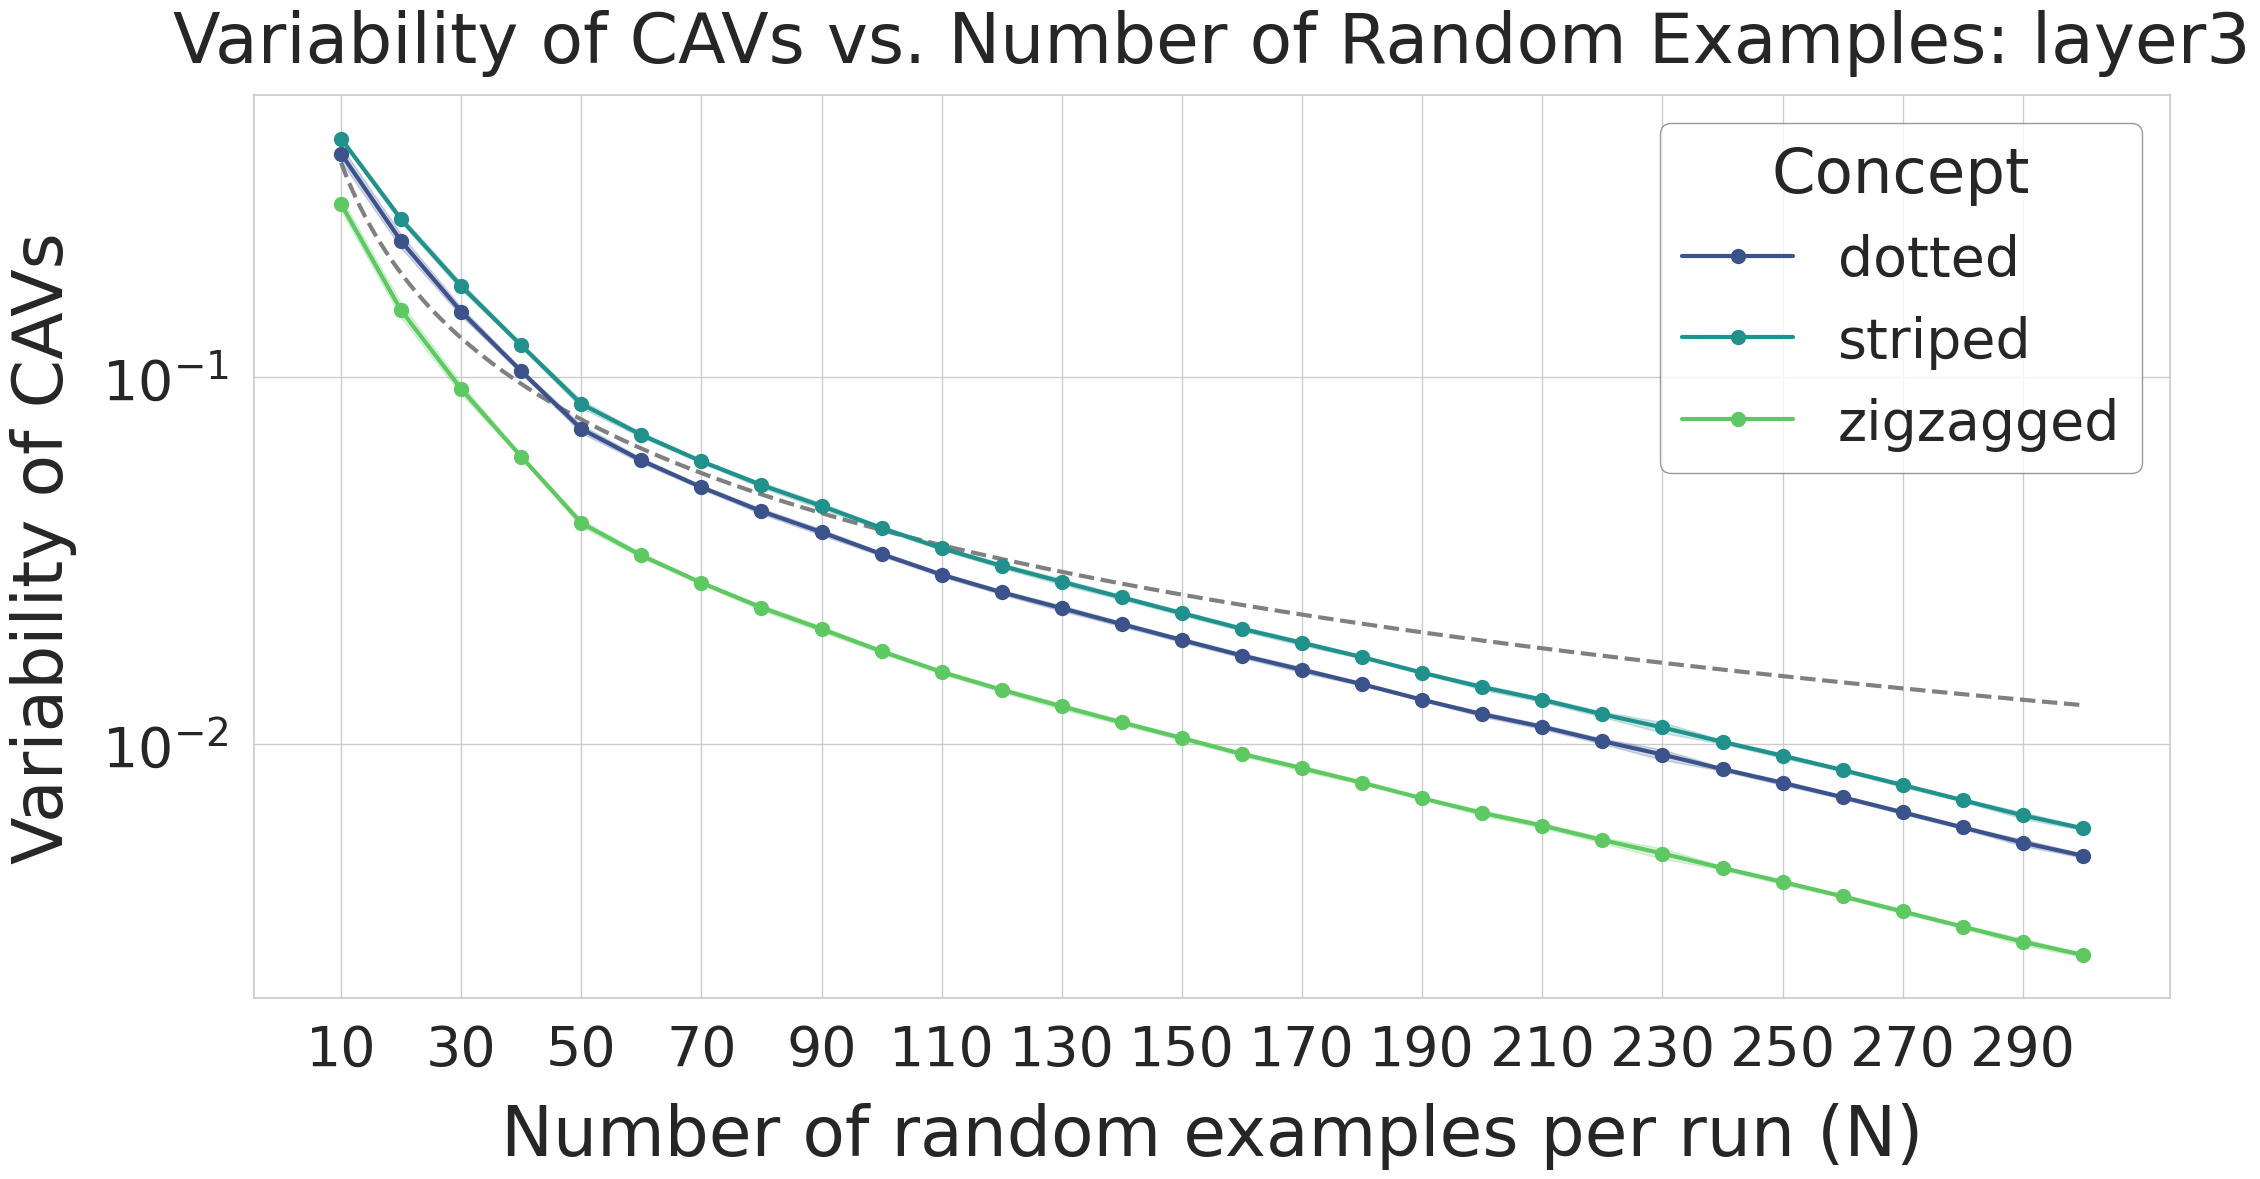

===== Analyzing Layer: layer4 =====
Fit: $ 5.92/N \; + \; 0.00417 $
Plot saved to artifacts/images/resnet50/dom/plots/cav_vector_variance_resnet50_layer4_dom.pdf


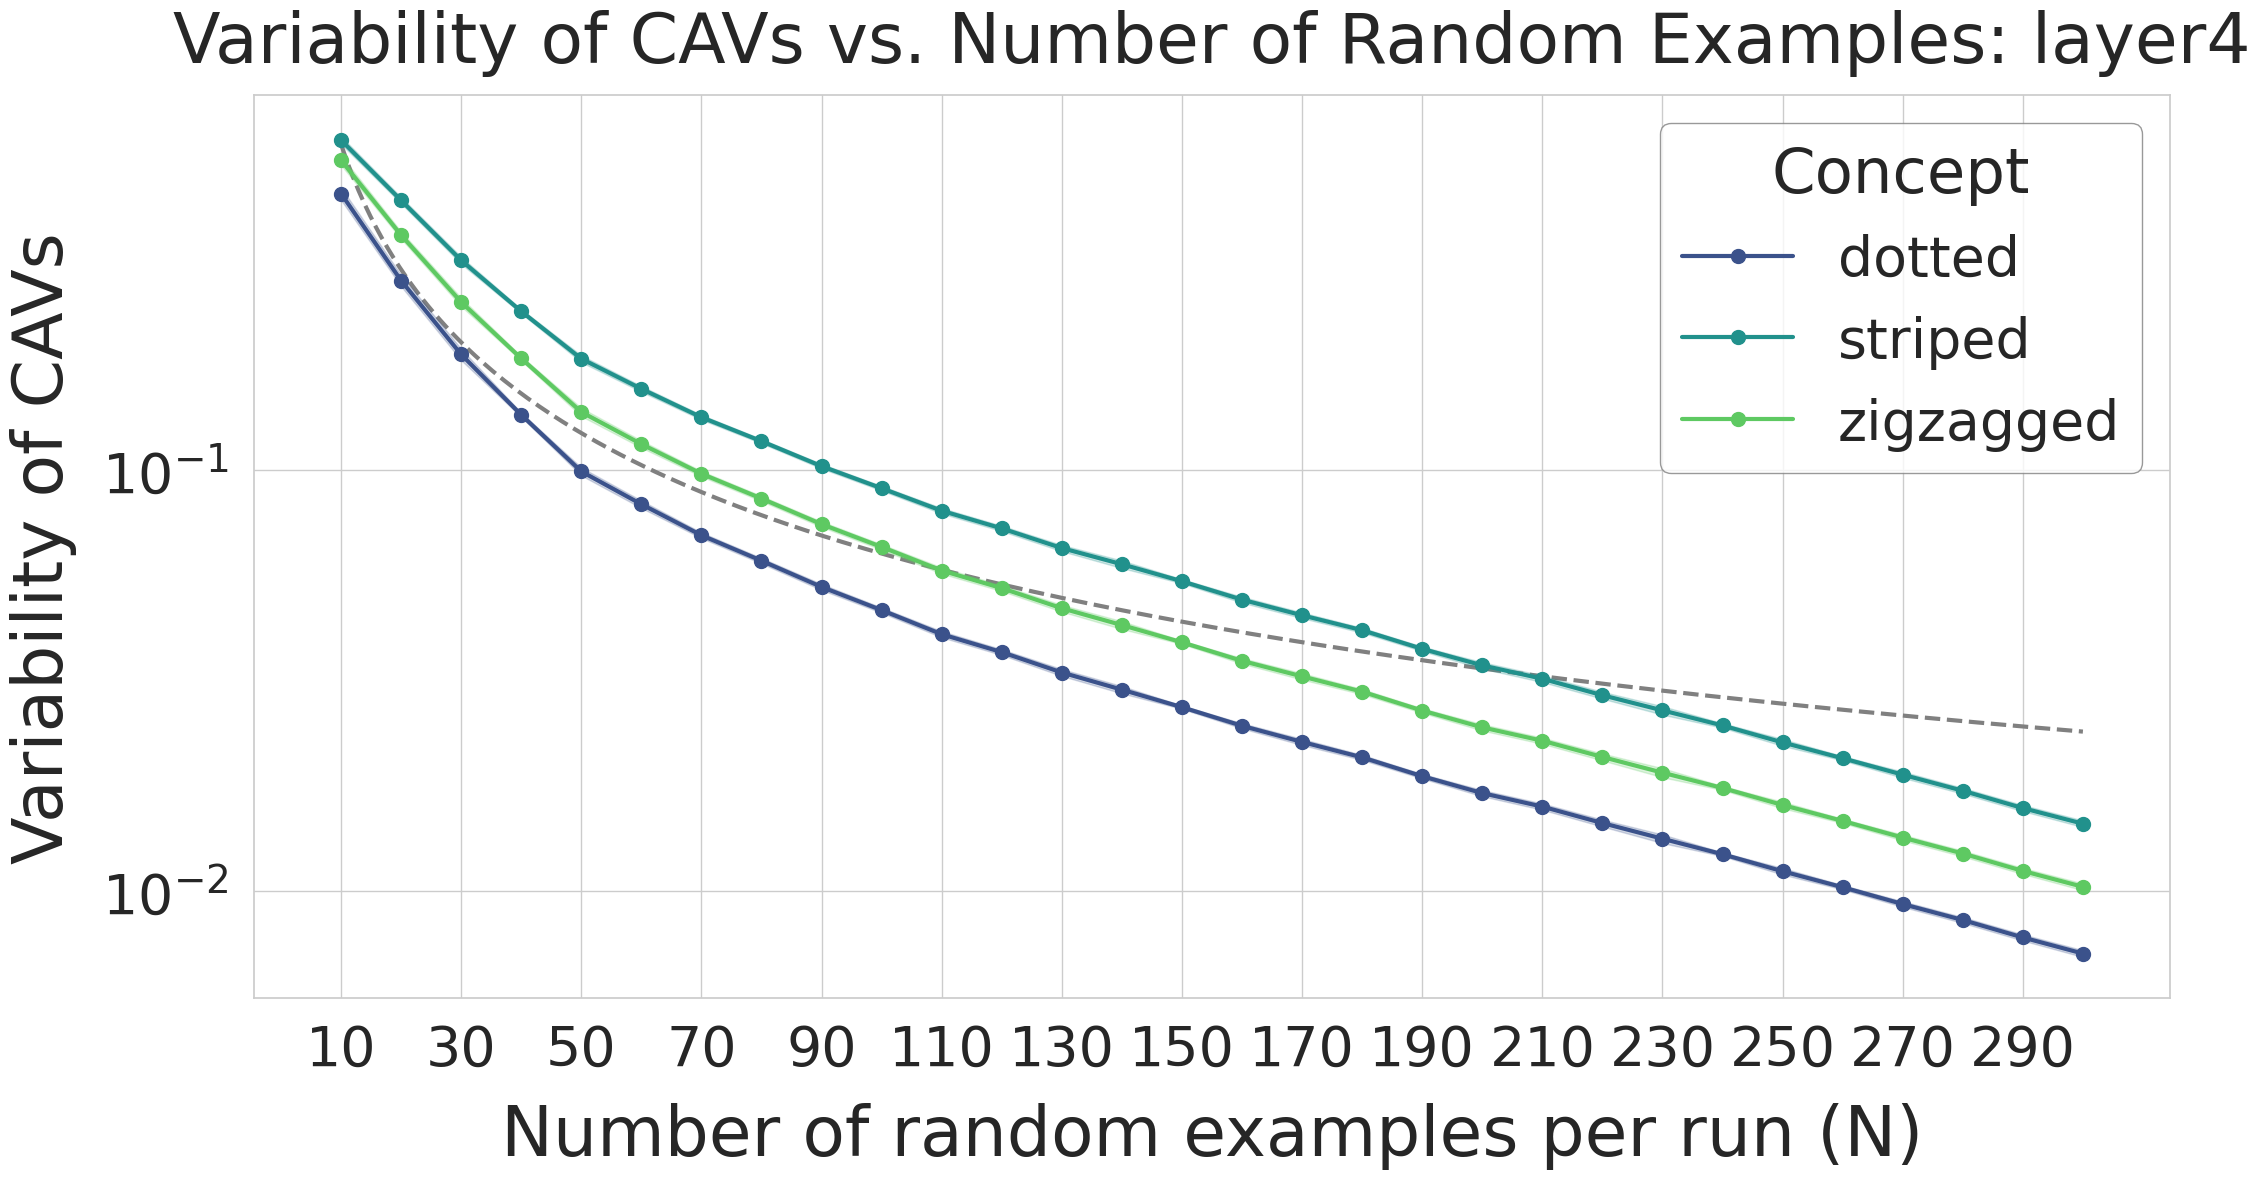

In [6]:

# -----------------------------
# 4) Your variability definition + styling (trace variance over CAV vectors)
# -----------------------------
for layer in layers:
    print(f"===== Analyzing Layer: {layer} =====")
    df_cav_variance = load_cav_vector_variance_data_cached(
        layer=layer,
        cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        cache_dir=CACHE_DIR,
        cache_key=f"trace_variance__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    plot_variance_vs_n(
        df=df_cav_variance,
        layer=layer,
        title=f"Variability of CAVs vs. Number of Random Examples: {layer}",
        ylabel="Variability of CAVs",
        save_path=os.path.join(cfg.out_dir, "plots", f"cav_vector_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        fit_thresholds=[0],
        cache_dir=CACHE_DIR,
        cache_key=f"cav_vector_variance_{MODEL}_{layer}_{METHOD}",
        load_if_exists=LOAD_IF_EXISTS,
        band="sd",
        save_bundle=True,
    )


Fit: $ 1.04\times 10^{-6}/N \; + \; 1.85\times 10^{-9} $
Plot saved to artifacts/images/resnet50/dom/plots/sensitivity_variance_resnet50_layer2_dom.pdf


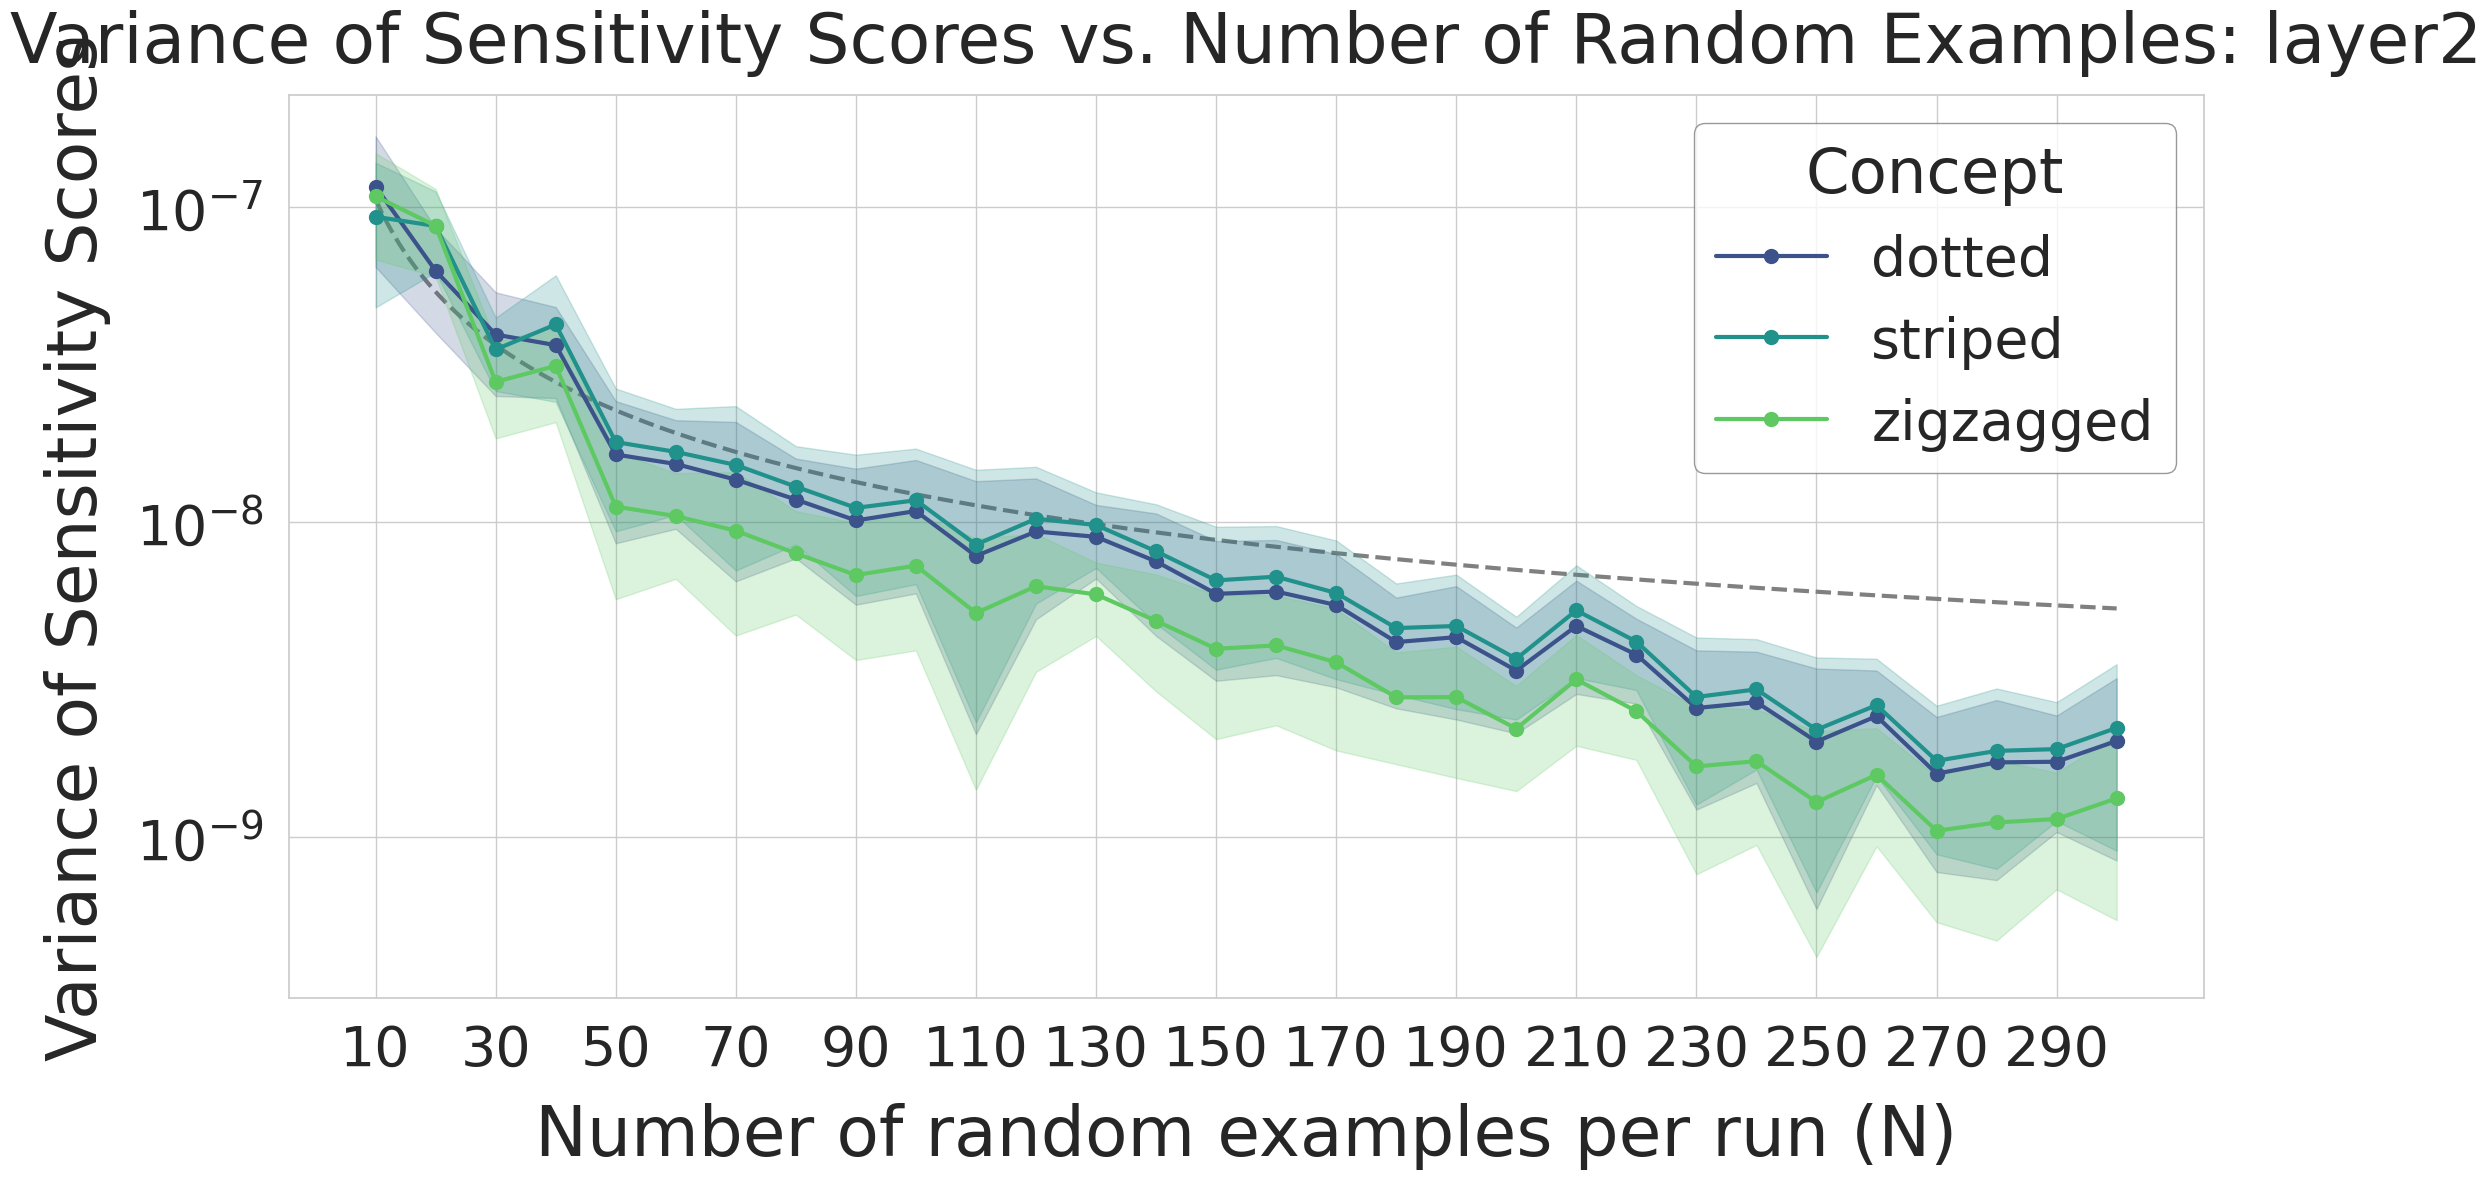

Fit: $ 3.41\times 10^{-6}/N \; + \; 4.7\times 10^{-9} $
Plot saved to artifacts/images/resnet50/dom/plots/sensitivity_variance_resnet50_layer3_dom.pdf


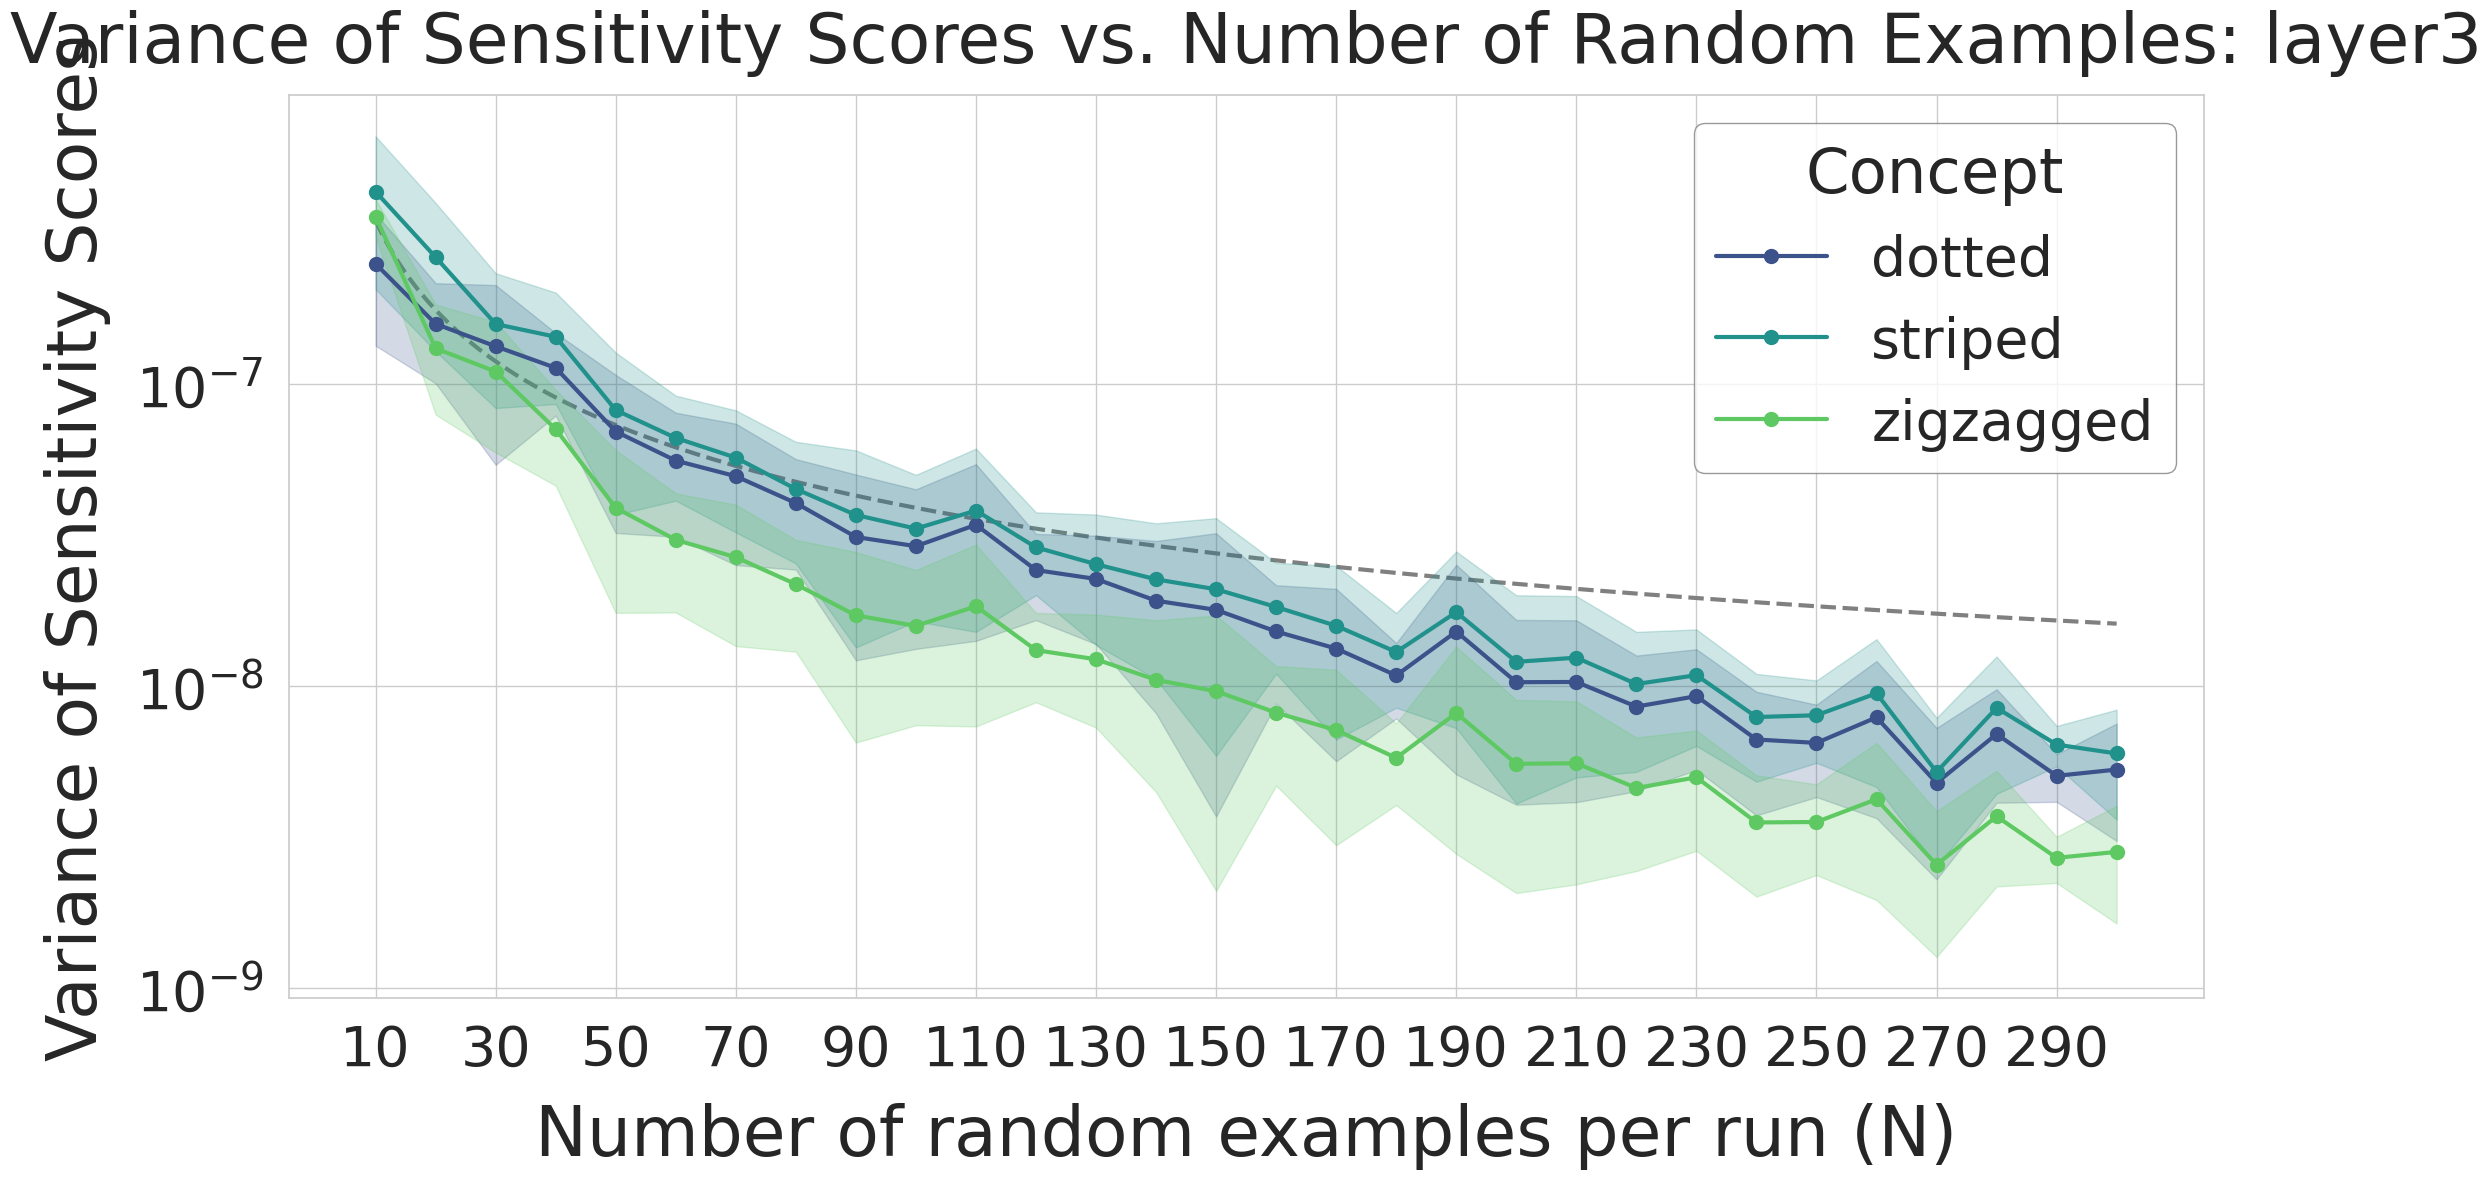

Fit: $ 2.89\times 10^{-4}/N \; + \; 8.08\times 10^{-8} $
Plot saved to artifacts/images/resnet50/dom/plots/sensitivity_variance_resnet50_layer4_dom.pdf


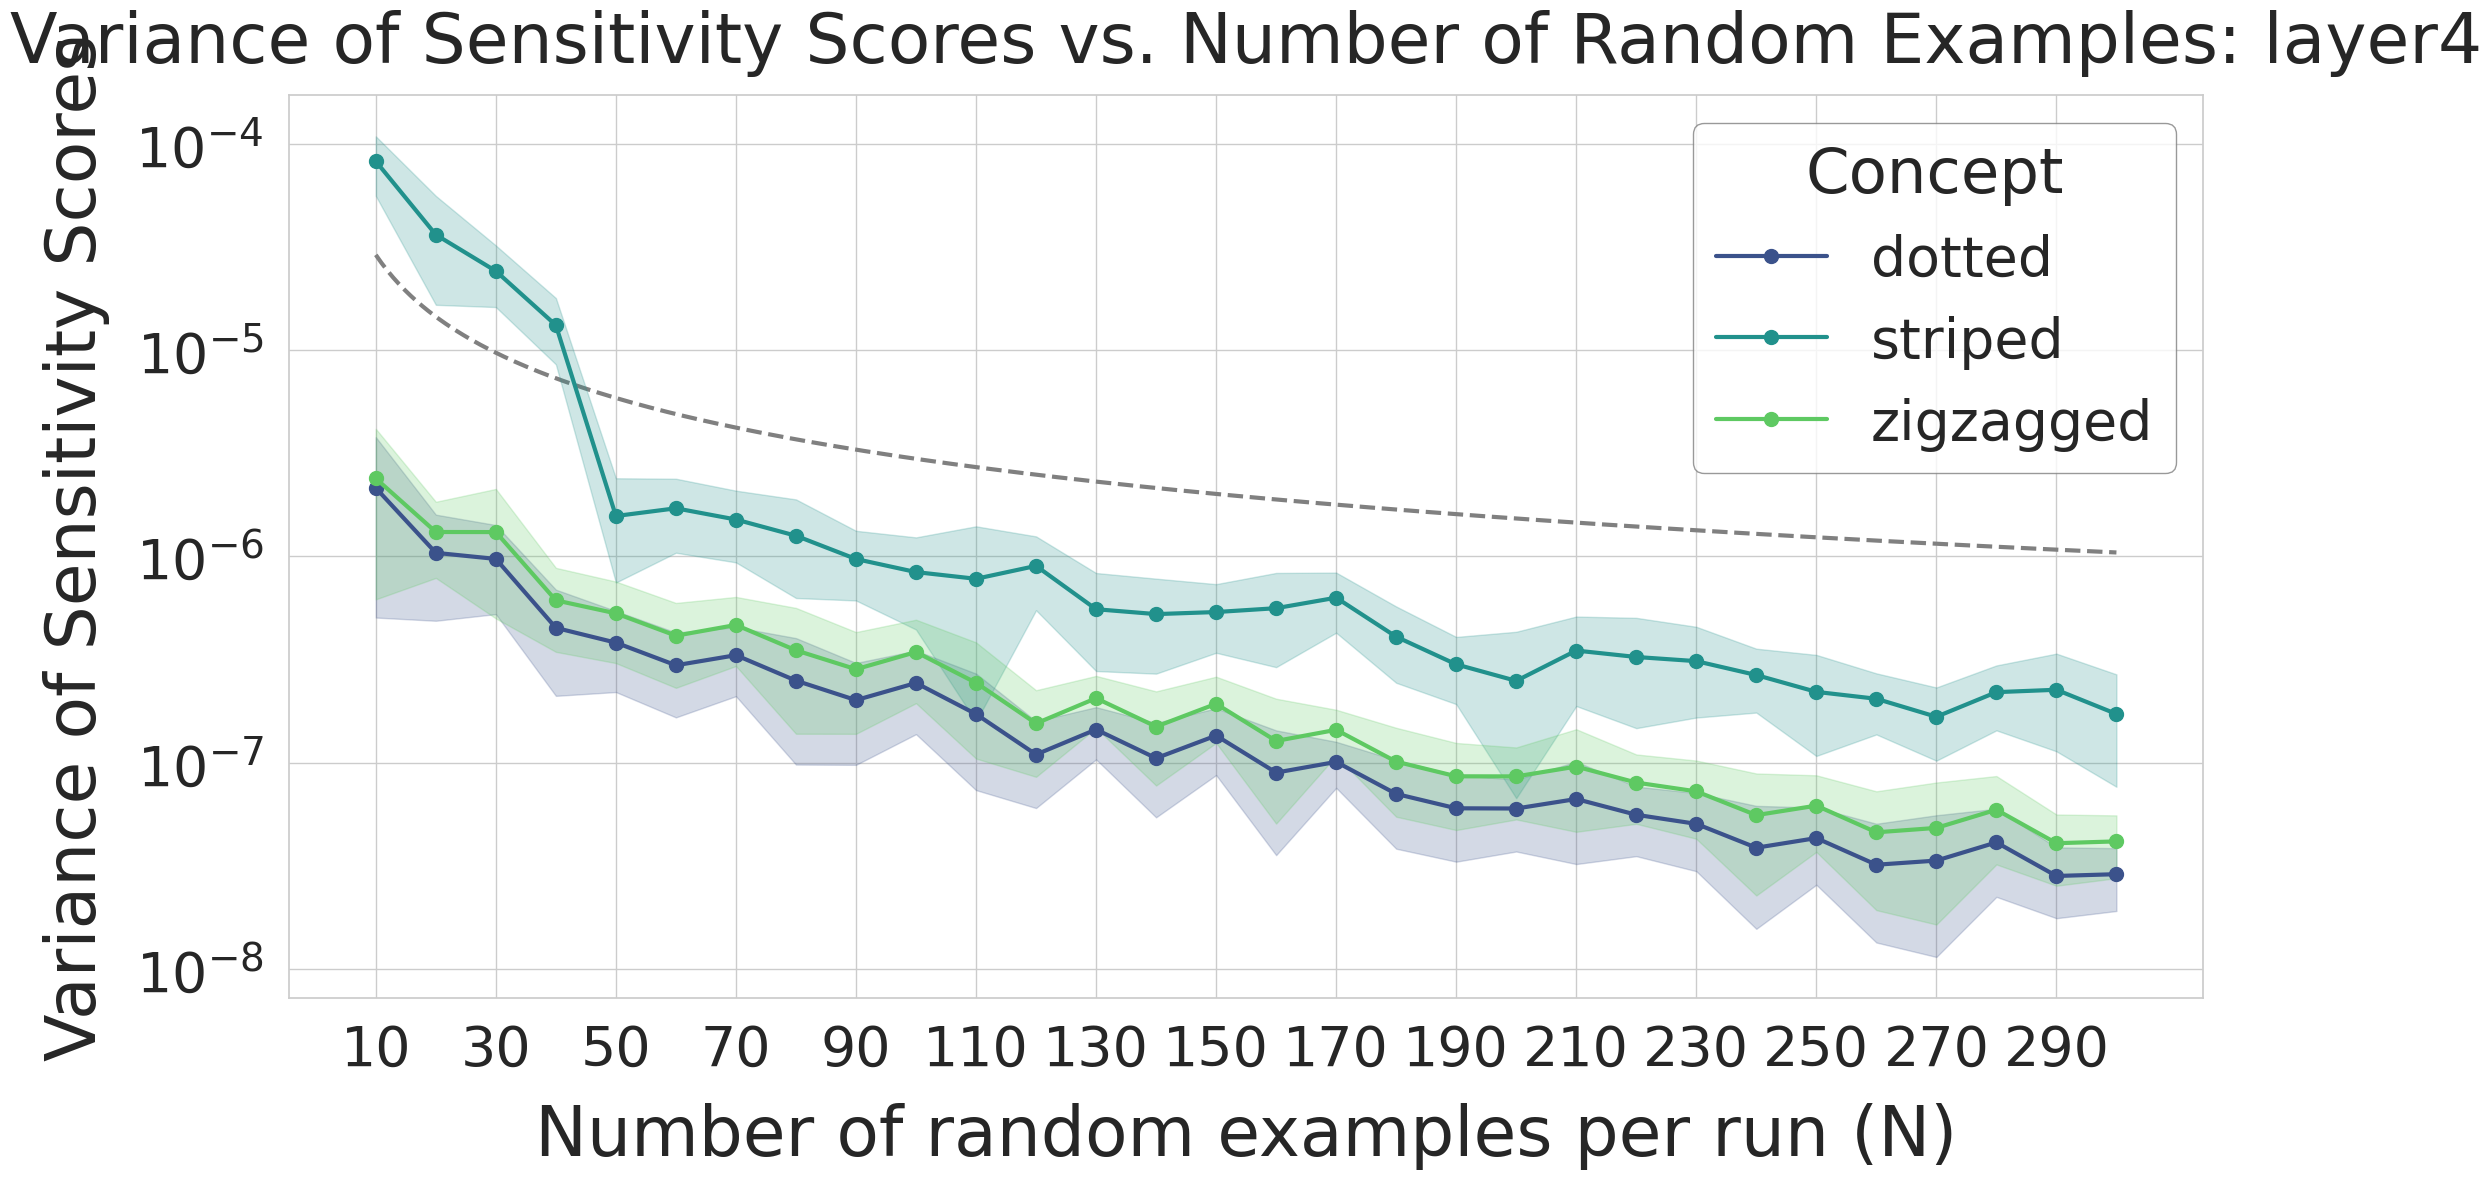

In [7]:

# -----------------------------
# 5) Sensitivity & TCAV score variance using your original definitions
#    - Sensitivity variance: variance over (cav · single-gradient-vector) across CAVs
#    - TCAV score variance: variance across CAVs of the fraction of positives over class gradients
# -----------------------------
from tcavlab.analysis_utils import (
    load_sensitivity_score_variance_data_cached,
    calculate_tcav_score_variance_cached
)

# (a) Compute a single gradient vector per layer for one target image (first example)
single_grad_by_layer = {}
first_img = class_tensor[0].unsqueeze(0).to(DEVICE)
for layer in layers:
    g = get_gradient_at_layer(model, first_img, layer, cfg.dataset.target_class_index, DEVICE)
    if g is not None:
        single_grad_by_layer[layer] = g[0]  # shape [D]
    else:
        print("No gradient for", layer)

# (b) Compute gradients for all class images per layer (for TCAV score variance)
grads_by_layer = precompute_gradients_for_class(model, class_tensor, layers, cfg.dataset.target_class_index, DEVICE)

# (c) Plot sensitivity variance per layer (all concepts on one figure)
for layer in layers:
    if layer not in single_grad_by_layer:
        print("Skipping sensitivity plot for", layer, "(no single gradient).")
        continue
    df_sens = load_sensitivity_score_variance_data_cached(
        layer=layer,
        gradient_vector=single_grad_by_layer[layer],
        cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        cache_dir=CACHE_DIR,
        cache_key=f"sens_score_var__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    plot_variance_vs_n(
        df=df_sens,
        layer=layer,
        title=f"Variance of Sensitivity Scores vs. Number of Random Examples: {layer}",
        ylabel="Variance of Sensitivity Scores",
        save_path=os.path.join(cfg.out_dir, "plots", f"sensitivity_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        fit_thresholds=[0],
        cache_dir=CACHE_DIR,
        cache_key=f"sens_var_plot__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save_bundle=True,
    )

In [8]:
# =============================================================
# α-TCAV: Smooth TCAV Score (Schnoor et al., UAI 2026)
# =============================================================
# Step 0: Inspect pickle structure

import numpy as np
import pandas as pd
import os, pickle

sample_layer = layers[0]
sample_concept = cfg.dataset.concepts[0]
sample_n = list(cfg.n_values)[0]
sample_path = os.path.join(cfg.out_dir, sample_layer, sample_concept, str(sample_n), "run_0.pkl")

with open(sample_path, "rb") as f:
    sample_data = pickle.load(f)

print(f"Pickle path: {sample_path}")
print(f"Type: {type(sample_data)}")

if isinstance(sample_data, list):
    print(f"List length: {len(sample_data)}")
    elem = sample_data[0]
    print(f"  Element[0] type: {type(elem)}")
    if isinstance(elem, dict):
        print(f"  Element[0] keys: {list(elem.keys())}")
        for k, v in elem.items():
            if hasattr(v, 'shape'):
                print(f"    '{k}': ndarray shape={v.shape}, dtype={v.dtype}")
            elif isinstance(v, (int, float, str, bool)):
                print(f"    '{k}': {type(v).__name__} = {v}")
            else:
                print(f"    '{k}': {type(v).__name__}, len={len(v) if hasattr(v, '__len__') else 'N/A'}")
    elif hasattr(elem, '__dict__'):
        print(f"  Element[0] attrs: {list(elem.__dict__.keys())}")
        for attr, val in elem.__dict__.items():
            if hasattr(val, 'shape'):
                print(f"    .{attr}: ndarray shape={val.shape}")
            else:
                print(f"    .{attr}: {type(val).__name__}")

print()
for layer in layers:
    if layer in grads_by_layer:
        g = grads_by_layer[layer]
        print(f"Gradients[{layer}]: shape={g.shape}")


Pickle path: artifacts/images/resnet50/dom/layer2/striped/10/run_0.pkl
Type: <class 'list'>
List length: 10
  Element[0] type: <class 'dict'>
  Element[0] keys: ['vector', 'bias', 'acc', 'method', 'meta']
    'vector': ndarray shape=(401408,), dtype=float32
    'bias': float = -39415.421875
    'acc': float = 1.0
    'method': str = dom
    'meta': dict, len=1

Gradients[layer2]: shape=(50, 401408)
Gradients[layer3]: shape=(50, 200704)
Gradients[layer4]: shape=(50, 100352)


In [9]:
# =============================================================
# Core α-TCAV functions
# =============================================================
import torch

def sigmoid_alpha(x, alpha):
    """Scaled sigmoid function σ_α(x) = 1/(1+exp(-αx))"""
    z = np.clip(-alpha * x, -500, 500)
    return 1.0 / (1.0 + np.exp(z))


def compute_alpha_tcav_score(cav_vector, gradient_matrix, alpha):
    """α-TCAV score = mean(σ_α(S)) where S = grad · cav."""
    sensitivities = gradient_matrix @ cav_vector
    return float(np.mean(sigmoid_alpha(sensitivities, alpha)))


def compute_standard_tcav_score(cav_vector, gradient_matrix):
    """Standard TCAV = mean(1{S > 0})."""
    sensitivities = gradient_matrix @ cav_vector
    return float(np.mean(sensitivities > 0))


def extract_cav_vectors_from_pickle(pkl_path):
    """
    Load a run pickle and return a list of 1-D CAV numpy arrays.
    
    Handles the actual tcavlab format:
      - list of dicts, each with a key like 'cav', 'vector', 'weights', 'coef_', 'direction', or 'w'
      - list of Concept objects with corresponding attributes
      - list of raw numpy arrays
      - 2-D numpy array (rows = CAVs)
      - single dict with a 'cavs' or 'vectors' key
    """
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)

    vectors = []

    if isinstance(data, list):
        for elem in data:
            vec = None

            if isinstance(elem, dict):
                # Try common key names for the CAV vector
                for key in ['cav', 'vector', 'weights', 'coef_', 'direction', 'w',
                            'cav_vector', 'weight', 'coefficients']:
                    if key in elem:
                        candidate = elem[key]
                        vec = np.asarray(candidate).flatten()
                        break
                # If no known key matched, try the first array-valued entry
                if vec is None:
                    for k, v in elem.items():
                        if isinstance(v, np.ndarray) and v.ndim >= 1 and v.size > 1:
                            vec = v.flatten()
                            break

            elif hasattr(elem, '__dict__'):
                # Object with attributes (e.g., Concept namedtuple / dataclass)
                for attr in ['cav', 'vector', 'weights', 'coef_', 'direction', 'w']:
                    if hasattr(elem, attr):
                        vec = np.asarray(getattr(elem, attr)).flatten()
                        break

            elif isinstance(elem, np.ndarray):
                vec = elem.flatten()

            if vec is not None and vec.size > 1:
                vectors.append(vec)

    elif isinstance(data, np.ndarray):
        if data.ndim == 2:
            vectors = [data[i].flatten() for i in range(data.shape[0])]
        elif data.ndim == 1 and data.size > 1:
            vectors = [data.flatten()]

    elif isinstance(data, dict):
        for key in ['cavs', 'cav', 'vectors', 'vector']:
            if key in data:
                val = data[key]
                if isinstance(val, list):
                    vectors = [np.asarray(v).flatten() for v in val]
                elif isinstance(val, np.ndarray) and val.ndim == 2:
                    vectors = [val[i].flatten() for i in range(val.shape[0])]
                break

    return vectors


# Quick sanity check
_test_vecs = extract_cav_vectors_from_pickle(
    os.path.join(cfg.out_dir, layers[0], cfg.dataset.concepts[0],
                 str(list(cfg.n_values)[0]), "run_0.pkl")
)
print(f"Sanity check: extracted {len(_test_vecs)} vectors, "
      f"first shape = {_test_vecs[0].shape if _test_vecs else 'EMPTY'}")
if _test_vecs:
    expected_dim = grads_by_layer[layers[0]].shape[1]
    print(f"Expected dim = {expected_dim}, CAV dim = {_test_vecs[0].shape[0]}, "
          f"match = {_test_vecs[0].shape[0] == expected_dim}")


Sanity check: extracted 10 vectors, first shape = (401408,)
Expected dim = 401408, CAV dim = 401408, match = True


In [10]:
def calculate_alpha_tcav_variance(
    layers, concepts_to_load, n_values, runs,
    gradients_per_layer, cav_output_dir, alpha_values,
):
    """
    Compute α-TCAV and standard TCAV scores for every (layer, concept, N, run, set).
    Each run pickle contains sets_per_run CAV vectors.
    """
    records = []

    for layer in layers:
        if layer not in gradients_per_layer:
            print(f"Skipping layer {layer} — no gradients.")
            continue

        grad_matrix = gradients_per_layer[layer]
        if isinstance(grad_matrix, torch.Tensor):
            grad_matrix = grad_matrix.cpu().numpy()
        
        expected_dim = grad_matrix.shape[1]
        print(f"Layer {layer}: grad shape={grad_matrix.shape}")

        for concept in concepts_to_load:
            n_skipped = 0
            for n in n_values:
                for run_idx in range(runs):
                    cav_path = os.path.join(
                        cav_output_dir, layer, concept, str(n), f"run_{run_idx}.pkl"
                    )
                    if not os.path.exists(cav_path):
                        continue

                    cav_vectors = extract_cav_vectors_from_pickle(cav_path)

                    for set_idx, cav_vec in enumerate(cav_vectors):
                        if cav_vec.shape[0] != expected_dim:
                            n_skipped += 1
                            continue

                        std_tcav = compute_standard_tcav_score(cav_vec, grad_matrix)
                        for alpha in alpha_values:
                            a_tcav = compute_alpha_tcav_score(cav_vec, grad_matrix, alpha)
                            records.append({
                                "layer": layer, "concept": concept,
                                "n": n, "alpha": alpha,
                                "run": run_idx, "set": set_idx,
                                "alpha_tcav_score": a_tcav,
                                "standard_tcav_score": std_tcav,
                            })

            if n_skipped:
                print(f"  {concept}: skipped {n_skipped} CAVs (dim mismatch)")

    df = pd.DataFrame(records)
    print(f"Total records: {len(df)}")
    return df


# =============================================================
# Run
# =============================================================
ALPHA_VALUES = [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]

df_alpha_tcav = calculate_alpha_tcav_variance(
    layers=layers,
    concepts_to_load=cfg.dataset.concepts,
    n_values=list(cfg.n_values),
    runs=int(cfg.runs),
    gradients_per_layer=grads_by_layer,
    cav_output_dir=cfg.out_dir,
    alpha_values=ALPHA_VALUES,
)
print(f"\nShape: {df_alpha_tcav.shape}")
print(df_alpha_tcav.head(10))


Layer layer2: grad shape=(50, 401408)
Layer layer3: grad shape=(50, 200704)
Layer layer4: grad shape=(50, 100352)
Total records: 189000

Shape: (189000, 8)
    layer  concept   n  alpha  run  set  alpha_tcav_score  standard_tcav_score
0  layer2  striped  10    0.1    0    0          0.500008                 0.64
1  layer2  striped  10    0.5    0    0          0.500040                 0.64
2  layer2  striped  10    1.0    0    0          0.500080                 0.64
3  layer2  striped  10    5.0    0    0          0.500401                 0.64
4  layer2  striped  10   10.0    0    0          0.500802                 0.64
5  layer2  striped  10   50.0    0    0          0.504007                 0.64
6  layer2  striped  10  100.0    0    0          0.508000                 0.64
7  layer2  striped  10    0.1    0    1          0.499999                 0.42
8  layer2  striped  10    0.5    0    1          0.499997                 0.42
9  layer2  striped  10    1.0    0    1          0.499

In [11]:
# =============================================================
# Plot: α-TCAV variance vs standard TCAV variance
# =============================================================
from scipy.optimize import curve_fit

def fit_func(N, a, b):
    return a / N + b


def plot_alpha_tcav_variance_comparison(df, layer, concept, alpha_values, save_path=None):
    """Side-by-side: standard TCAV var vs α-TCAV var for different α."""
    df_sub = df[(df["layer"] == layer) & (df["concept"] == concept)].copy()
    if df_sub.empty:
        print(f"No data for {layer}/{concept}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # --- Left: All methods on one plot ---
    ax = axes[0]

    # Standard TCAV variance (aggregate over runs × sets)
    std_var = (
        df_sub.drop_duplicates(subset=["n", "run", "set"])  # one std_tcav per (n, run, set)
        .groupby("n")["standard_tcav_score"]
        .var()
        .reset_index()
        .rename(columns={"standard_tcav_score": "variance"})
    )
    ax.plot(std_var["n"], std_var["variance"], "k-o", label="Standard TCAV",
            linewidth=2, markersize=4)

    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(alpha_values)))
    for alpha, color in zip(alpha_values, colors):
        alpha_var = (
            df_sub[df_sub["alpha"] == alpha]
            .groupby("n")["alpha_tcav_score"]
            .var()
            .reset_index()
            .rename(columns={"alpha_tcav_score": "variance"})
        )
        ax.plot(alpha_var["n"], alpha_var["variance"], "-o", color=color,
                label=f"α={alpha}", linewidth=1.5, markersize=3)

    ax.set_xlabel("Number of random examples (N)", fontsize=12)
    ax.set_ylabel("Variance of (α-)TCAV Score", fontsize=12)
    ax.set_title(f"TCAV vs α-TCAV Variance — {layer} / {concept}", fontsize=13)
    ax.set_yscale("log")
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

    # --- Right: 1/N fit comparison ---
    ax2 = axes[1]

    # Fit standard TCAV
    if len(std_var) > 3:
        try:
            popt, _ = curve_fit(fit_func, std_var["n"].values, std_var["variance"].values,
                                p0=[1.0, 0.001], maxfev=5000)
            n_fit = np.linspace(std_var["n"].min(), std_var["n"].max(), 200)
            ax2.plot(n_fit, fit_func(n_fit, *popt), "k--",
                     label=f"Std TCAV: {popt[0]:.3g}/N + {popt[1]:.3g}")
        except Exception:
            pass
    ax2.plot(std_var["n"], std_var["variance"], "ko", markersize=4, label="Std TCAV data")

    for alpha in [1.0, 10.0]:
        alpha_var = (
            df_sub[df_sub["alpha"] == alpha]
            .groupby("n")["alpha_tcav_score"]
            .var()
            .reset_index()
            .rename(columns={"alpha_tcav_score": "variance"})
        )
        if len(alpha_var) > 3:
            try:
                popt, _ = curve_fit(fit_func, alpha_var["n"].values, alpha_var["variance"].values,
                                    p0=[1.0, 0.001], maxfev=5000)
                n_fit = np.linspace(alpha_var["n"].min(), alpha_var["n"].max(), 200)
                ax2.plot(n_fit, fit_func(n_fit, *popt), "--",
                         label=f"α={alpha}: {popt[0]:.3g}/N + {popt[1]:.3g}")
            except Exception:
                pass
        ax2.plot(alpha_var["n"], alpha_var["variance"], "o", markersize=4, label=f"α={alpha} data")

    ax2.set_xlabel("Number of random examples (N)", fontsize=12)
    ax2.set_ylabel("Variance", fontsize=12)
    ax2.set_title(f"1/N Fit Comparison — {layer} / {concept}", fontsize=13)
    ax2.set_yscale("log")
    ax2.legend(fontsize=8)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {save_path}")
    plt.show()


Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer2_striped_dom.pdf


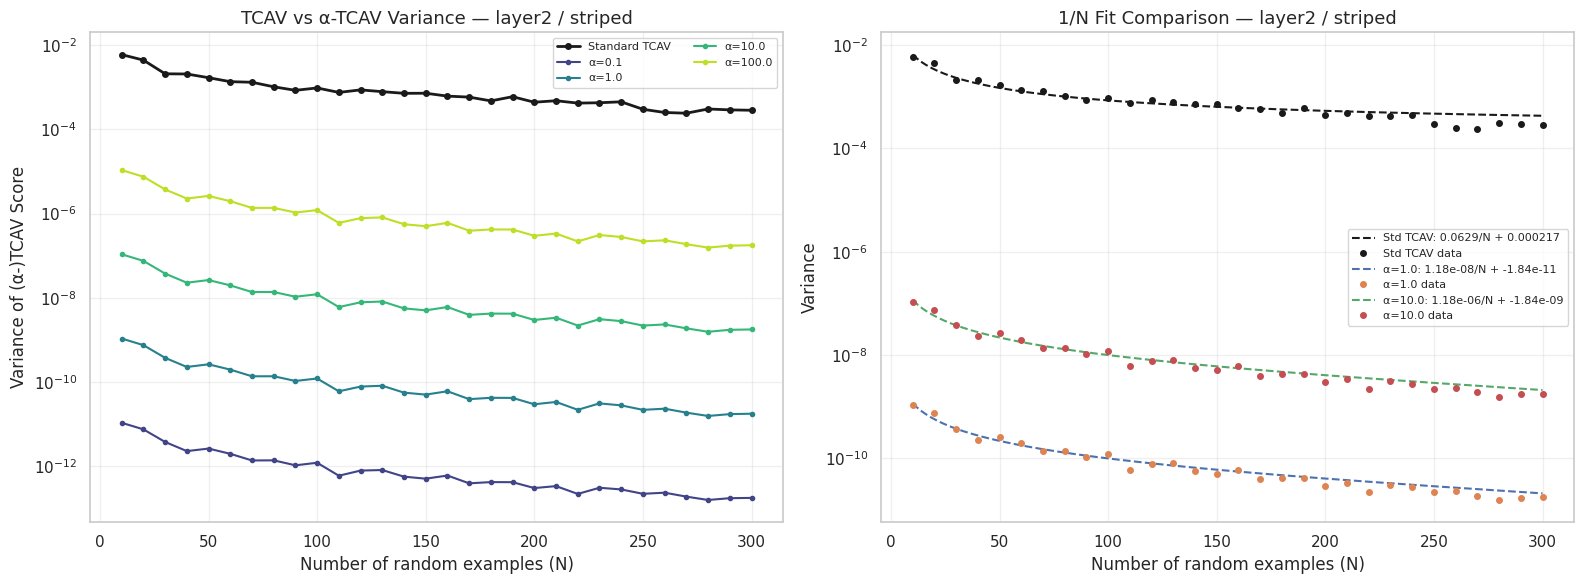

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer2_zigzagged_dom.pdf


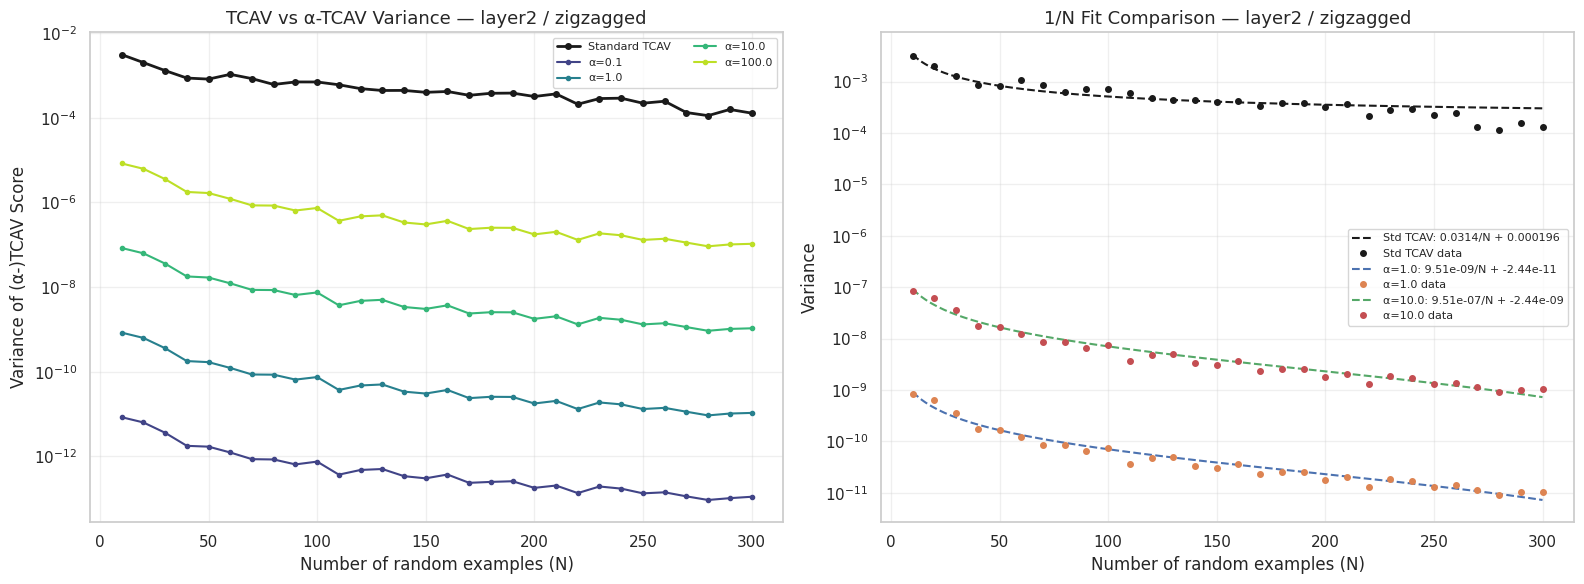

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer2_dotted_dom.pdf


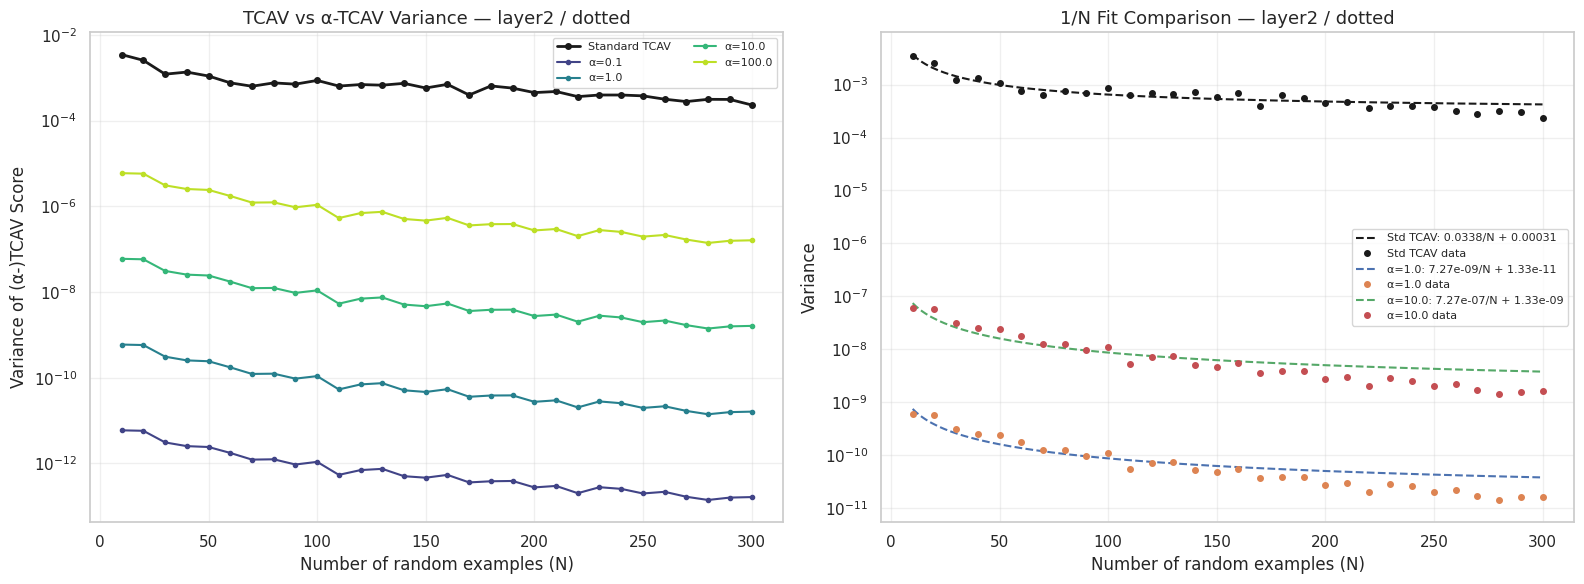

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer3_striped_dom.pdf


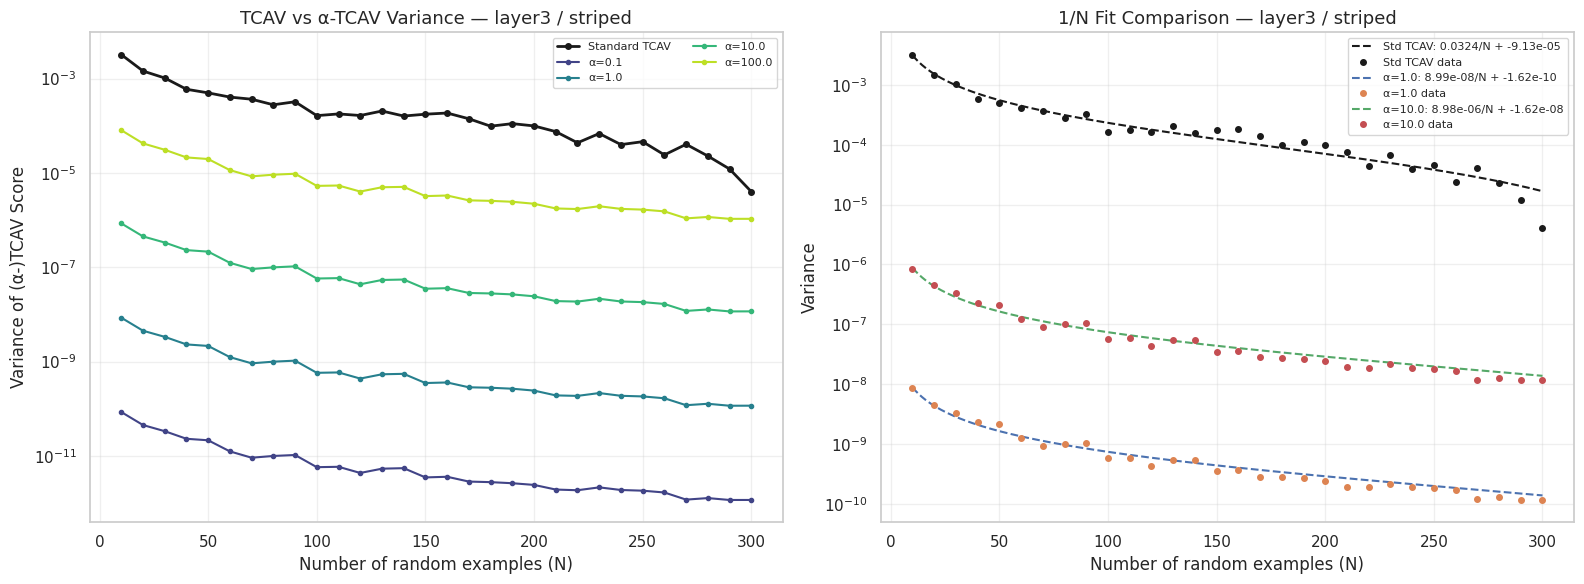

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer3_zigzagged_dom.pdf


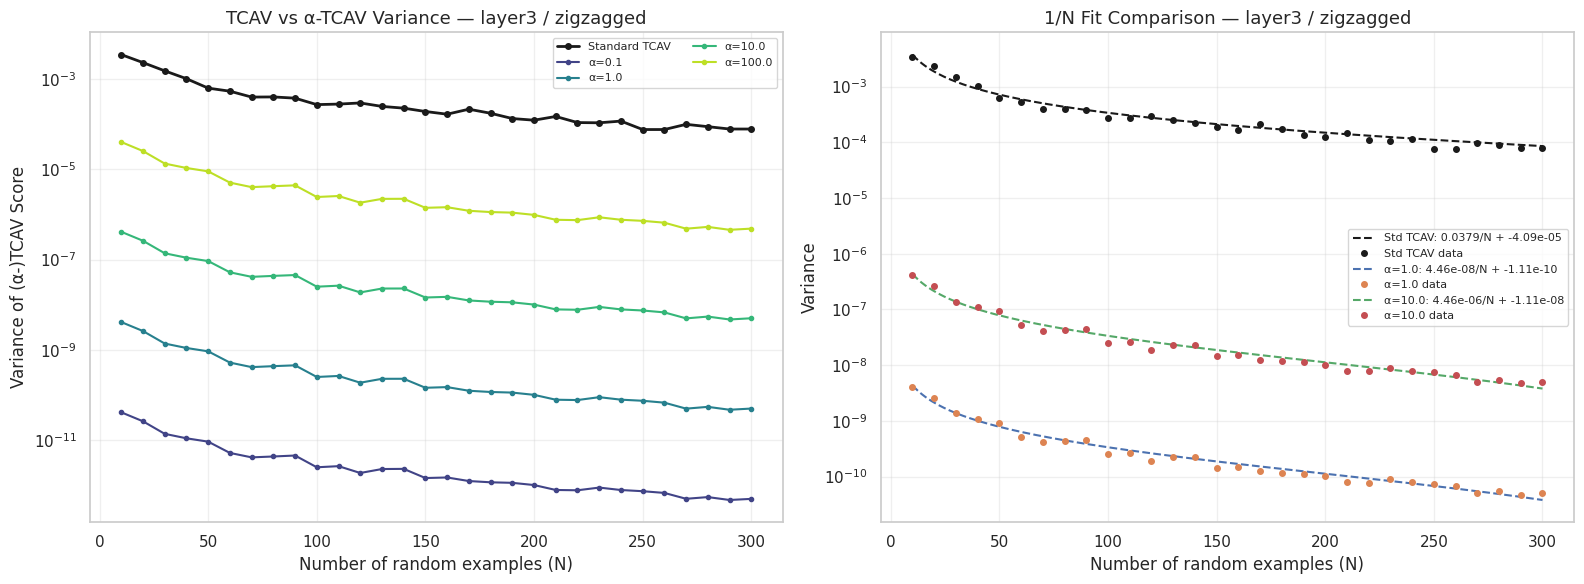

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer3_dotted_dom.pdf


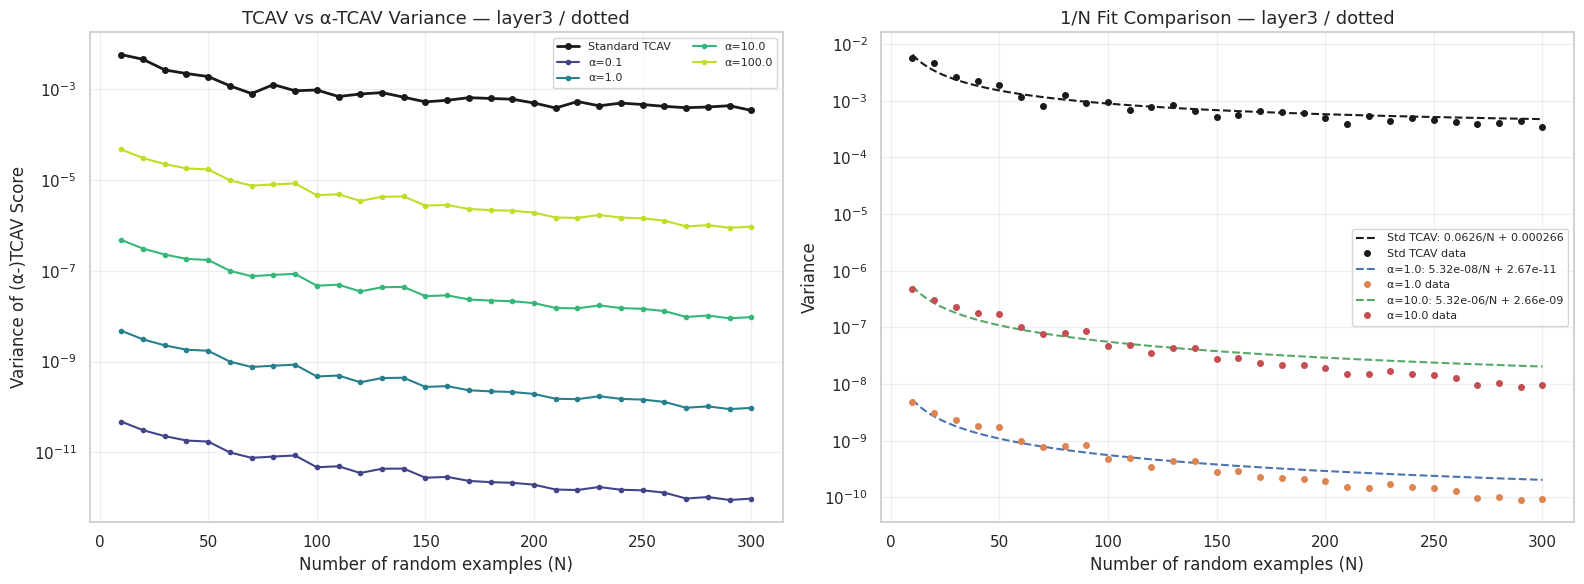

/tmp/ipykernel_2162652/3430450684.py:58: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_func, std_var["n"].values, std_var["variance"].values,


Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer4_striped_dom.pdf


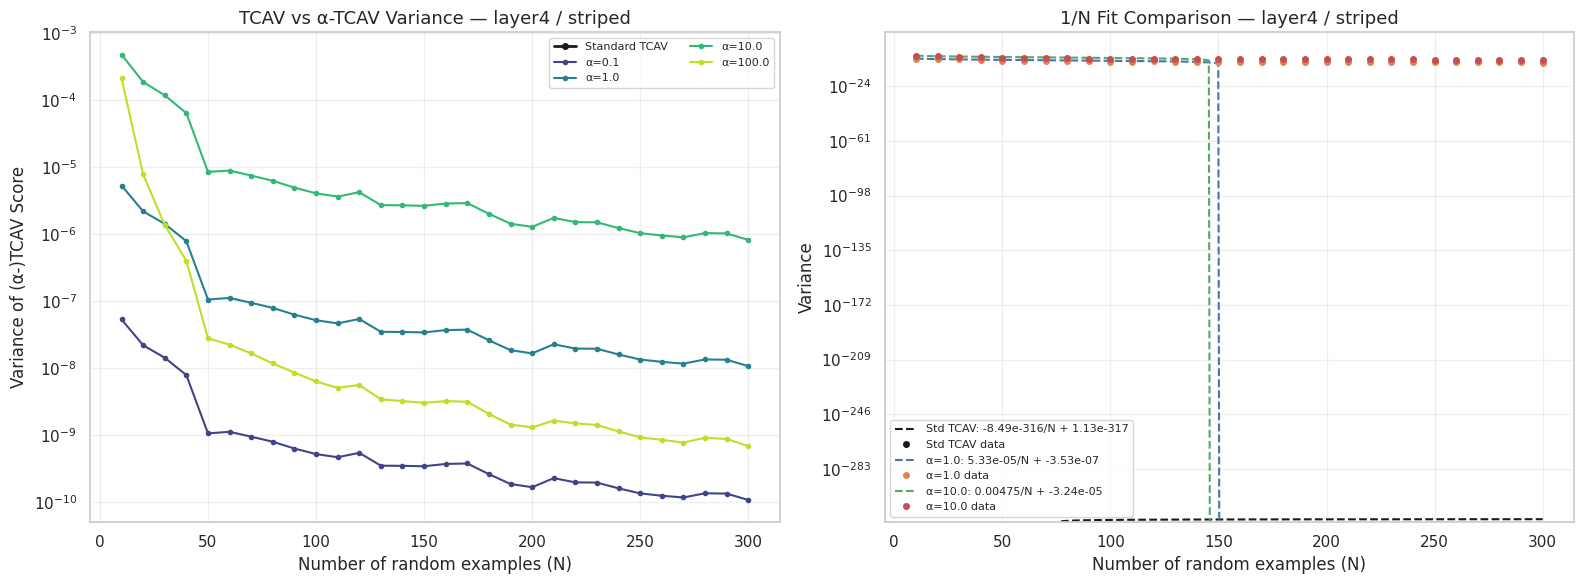

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer4_zigzagged_dom.pdf


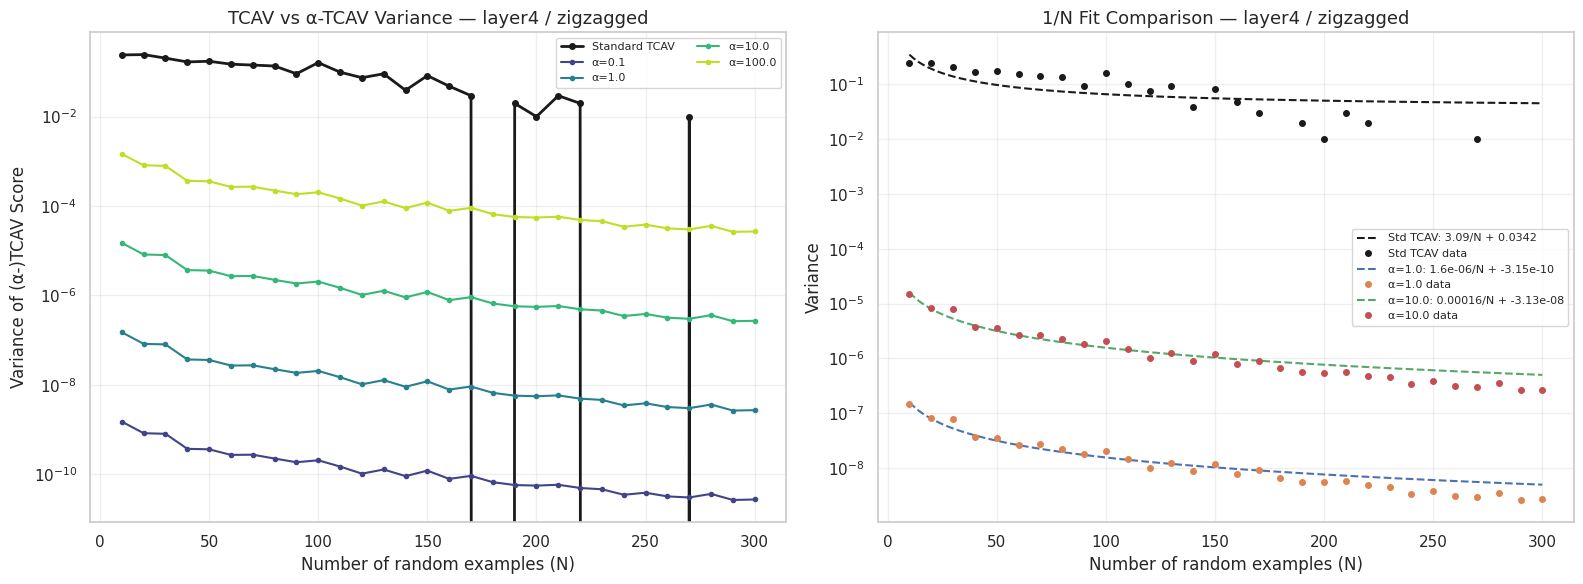

Saved: artifacts/images/resnet50/dom/plots/alpha_tcav_comparison_resnet50_layer4_dotted_dom.pdf


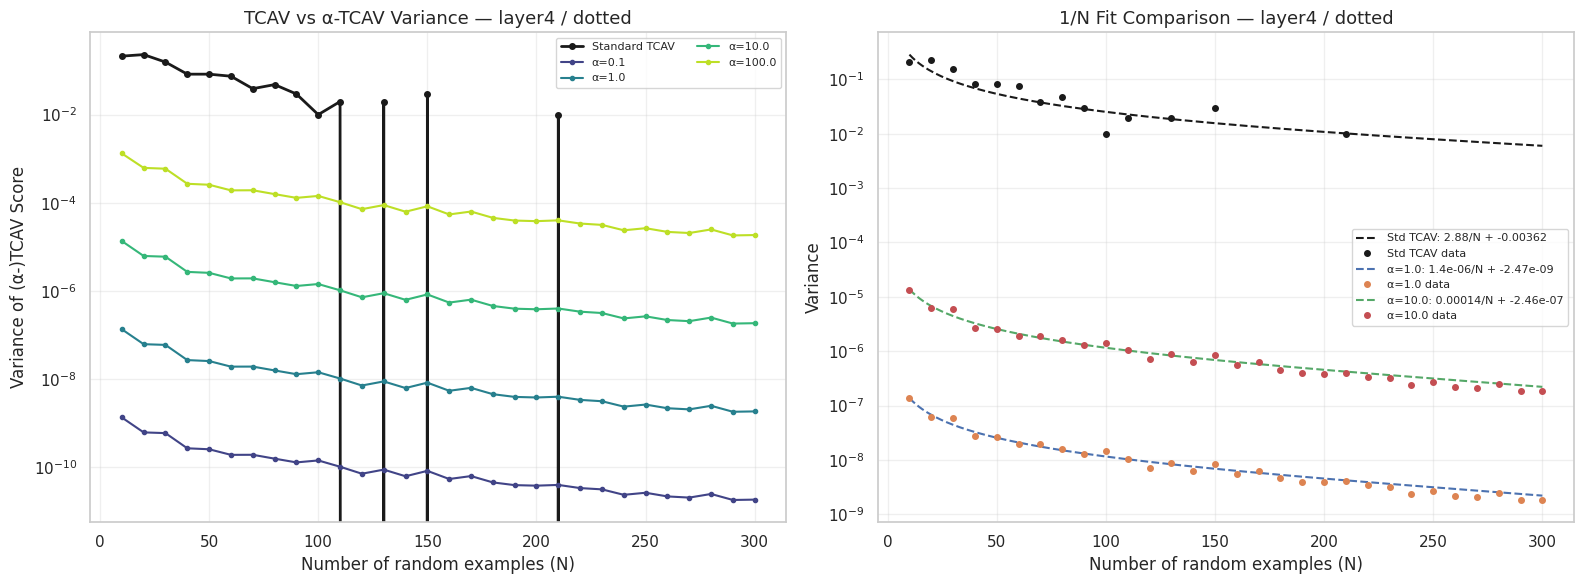

In [12]:
# =============================================================
# Generate comparison plots
# =============================================================
PLOT_ALPHAS = [0.1, 1.0, 10.0, 100.0]

for layer in layers:
    for concept in cfg.dataset.concepts:
        save_path = os.path.join(
            cfg.out_dir, "plots",
            f"alpha_tcav_comparison_{MODEL}_{layer}_{concept}_{METHOD}.pdf"
        )
        plot_alpha_tcav_variance_comparison(
            df=df_alpha_tcav,
            layer=layer,
            concept=concept,
            alpha_values=PLOT_ALPHAS,
            save_path=save_path,
        )


In [13]:
# =============================================================
# Summary table: variance decay rates
# =============================================================
summary_records = []

for layer in layers:
    for concept in cfg.dataset.concepts:
        df_sub = df_alpha_tcav[(df_alpha_tcav["layer"] == layer) &
                               (df_alpha_tcav["concept"] == concept)]
        if df_sub.empty:
            continue

        # Standard TCAV
        std_var = (
            df_sub.drop_duplicates(subset=["n", "run", "set"])
            .groupby("n")["standard_tcav_score"].var().reset_index()
        )
        try:
            popt, _ = curve_fit(fit_func, std_var["n"].values,
                                std_var["standard_tcav_score"].values,
                                p0=[1.0, 0.001], maxfev=5000)
            summary_records.append({
                "layer": layer, "concept": concept, "method": "Standard TCAV",
                "a (1/N term)": f"{popt[0]:.4g}", "b (constant)": f"{popt[1]:.4g}",
            })
        except Exception:
            pass

        for alpha in ALPHA_VALUES:
            alpha_var = (df_sub[df_sub["alpha"] == alpha]
                         .groupby("n")["alpha_tcav_score"].var().reset_index())
            try:
                popt, _ = curve_fit(fit_func, alpha_var["n"].values,
                                    alpha_var["alpha_tcav_score"].values,
                                    p0=[1.0, 0.001], maxfev=5000)
                summary_records.append({
                    "layer": layer, "concept": concept, "method": f"α-TCAV (α={alpha})",
                    "a (1/N term)": f"{popt[0]:.4g}", "b (constant)": f"{popt[1]:.4g}",
                })
            except Exception:
                pass

df_summary = pd.DataFrame(summary_records)
print("\n=== Variance Decay Summary: f(N) = a/N + b ===")
print("Large |a|, small |b| → variance decays with N (good stability)")
print("Small |a|, large |b| → variance is flat / O(1) (borderline point issue)")
print()
display(df_summary) if hasattr(__builtins__, 'display') else print(df_summary.to_string(index=False))



=== Variance Decay Summary: f(N) = a/N + b ===
Large |a|, small |b| → variance decays with N (good stability)
Small |a|, large |b| → variance is flat / O(1) (borderline point issue)



/tmp/ipykernel_2162652/451552642.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_func, std_var["n"].values,


layer  concept            method a (1/N term) b (constant)
0   layer2  striped     Standard TCAV       0.0629    0.0002167
1   layer2  striped    α-TCAV (α=0.1)    1.184e-10   -1.814e-13
2   layer2  striped    α-TCAV (α=0.5)    2.956e-09   -4.594e-12
3   layer2  striped    α-TCAV (α=1.0)    1.183e-08   -1.838e-11
4   layer2  striped    α-TCAV (α=5.0)    2.956e-07   -4.595e-10
..     ...      ...               ...          ...          ...
67  layer4   dotted    α-TCAV (α=1.0)    1.401e-06   -2.466e-09
68  layer4   dotted    α-TCAV (α=5.0)    3.502e-05   -6.162e-08
69  layer4   dotted   α-TCAV (α=10.0)    0.0001401   -2.462e-07
70  layer4   dotted   α-TCAV (α=50.0)     0.003479   -5.984e-06
71  layer4   dotted  α-TCAV (α=100.0)      0.01364    -2.19e-05

[72 rows x 5 columns]

In [ ]:
!pkill -u said -f jupyter